 # PaddleX助力无人驾驶（基于YOLOv3的车辆检测和车道线分割）


## 项目简介：

该项目使用**PaddleX**提供的YOLOv3模型，在 UA-DETRAC 车辆检测数据集进行训练；

训练结果能够检测到car，van，bus等不同类型车辆，mAP为0.799；

并使用开源车道检测算法，实现了无人驾驶部分的视觉感知——车辆检测和车道线分割；

该项目使用CPU环境或GPU环境运行，PaddleX会自动选择合适的环境；

## 目录：

0. PaddleX工具简介；
1. 安装PaddleX；
2. 设置工作环境；
3. 数据集简介；
4. 生成训练所需文件；
5. 设置图像数据预处理和数据增强模块；
6. 定义数据迭代器；
7. 定义YOLOv3模型并开始训练；
8. 评估模型性能；
9. 加载模型并用于测试；
10. 车道线分割模块；
11. 总结

## 项目目标：

1. 学会使用PaddleX目标检测模块训练自己的数据集；
1. 熟练使用Paddlex提高开发效率；
1. 使用PaddleX进行基于YOLOv3的车辆检测和车道线分割项目开发；

## 最终效果：

![](https://ai-studio-static-online.cdn.bcebos.com/42a242c0e8be4bbc8092044c2b058163e6f2416f19f440129d21c3d2530d69d6)


# PaddleX工具简介：

![](https://ai-studio-static-online.cdn.bcebos.com/36ddce8a108641eaacdce72c0d43c6b841523961829d43929c6f9c45b8ebba8e)

**PaddleX简介**：PaddleX是飞桨全流程开发工具，集飞桨核心框架、模型库、工具及组件等深度学习开发所需全部能力于一身，打通深度学习开发全流程，并提供简明易懂的Python API，方便用户根据实际生产需求进行直接调用或二次开发，为开发者提供飞桨全流程开发的最佳实践。目前，该工具代码已开源于GitHub，同时可访问PaddleX在线使用文档，快速查阅读使用教程和API文档说明。

**PaddleX代码GitHub链接**：https://github.com/PaddlePaddle/PaddleX/tree/develop

**PaddleX文档链接**：https://paddlex.readthedocs.io/zh_CN/latest/index.html

**PaddleX官网链接**：https://www.paddlepaddle.org.cn/paddle/paddlex

![](https://ai-studio-static-online.cdn.bcebos.com/8c38d37fa83e44f7af5574ab395df925080903edab90485c8b2cb7ca7cf750dd)


# 1. 安装PaddleX库：

> pip install paddlex -i https://mirror.baidu.com/pypi/simple

In [ ]:
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

# 2. 设置工作路径，并使用0号GPU卡

In [1]:

import matplotlib
matplotlib.use('Agg') 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import paddlex as pdx

os.chdir('/home/aistudio/work/')

# 3. 数据集：

**数据集简介：**

数据集使用 UA-DETRAC 数据集，是一个具有挑战性的真实多目标检测和多目标跟踪基准。

该数据集由10小时的视频组成，这些视频由中国北京和天津的24个不同地点使用Cannon EOS 550D摄像机拍摄。

视频以每秒 25 帧 （fps） 的速度录制，分辨率为 960×540 像素。

UA-DETRAC 数据集中有超过 140 000 个帧，手动标注了 8250 辆车，总共有 121 万个标记了边界框的目标。

![](https://ai-studio-static-online.cdn.bcebos.com/edd898bd96b14bc489f1e8208fb79bce4c79886ab7b348688d46d3c368bbb5b1)


# 4. 生成所需文件：

这里的PaddleX同时支持VOC和COCO两种格式的数据；

需要的文件有：

1. labels.txt：保存目标类别的文件，不包括背景类；

![](https://ai-studio-static-online.cdn.bcebos.com/0957d113c26f4fce8a645ba8735d5b4456fa4544fb3449b68f708c3f80c9650f)

2. train_list.txt和val_list.txt：保存训练/测试所需的图片和标注文件的相对路径；

![](https://ai-studio-static-online.cdn.bcebos.com/2c8ae1836af54caaa1cd9f5e5d7fc57968a658249cf54aeda51352fe77979086)



In [ ]:
!unzip /home/aistudio/data/data34332/VOC2012.zip -d ./

imgs = os.listdir('./VOC2012/JPEGImages')
print('total:', len(imgs))

with open('./VOC2012/train_list.txt', 'w') as f:
    for im in imgs[:-200]:
        info = 'JPEGImages/'+im+' '
        info += 'Annotations/'+im[:-4]+'.xml\n'
        f.write(info)

with open('./VOC2012/val_list.txt', 'w') as f:
    for im in imgs[-200:]:
        info = 'JPEGImages/'+im+' '
        info += 'Annotations/'+im[:-4]+'.xml\n'
        f.write(info)

total: 6000


# 5.设置图像数据预处理和数据增强模块：

具体参数见：

[https://paddlex.readthedocs.io/zh_CN/latest/apis/transforms/det_transforms.html](https://paddlex.readthedocs.io/zh_CN/latest/apis/transforms/det_transforms.html)

In [2]:

from paddlex.det import transforms
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250),
    transforms.RandomDistort(),
    transforms.RandomExpand(),
    transforms.RandomCrop(),
    transforms.Resize(target_size=608, interp='RANDOM'),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(),
])

eval_transforms = transforms.Compose([
    transforms.Resize(target_size=608, interp='CUBIC'),
    transforms.Normalize(),
])

# 6.定义数据迭代器：

参数

* **data_dir (str)**: 数据集所在的目录路径。

* **file_list (str)**: 描述数据集图片文件和对应标注文件的文件路径（文本内每行路径为相对data_dir的相对路径）。

* **label_list (str)**: 描述数据集包含的类别信息文件路径。

* **transforms (paddlex.det.transforms)**: 数据集中每个样本的预处理/增强算子，详见paddlex.det.transforms。

* **num_workers (int|str)**：数据集中样本在预处理过程中的线程或进程数。默认为’auto’。当设为’auto’时，根据系统的实际CPU核数设置num_workers: 如果CPU核数的一半大于8，则num_workers为8，否则为CPU核数的一半。

* **buffer_size (int)**: 数据集中样本在预处理过程中队列的缓存长度，以样本数为单位。默认为100。

* **parallel_method (str)**: 数据集中样本在预处理过程中并行处理的方式，支持’thread’线程和’process’进程两种方式。默认为’thread’（Windows和Mac下会强制使用thread，该参数无效）。

* **shuffle (bool)**: 是否需要对数据集中样本打乱顺序。默认为False。

In [3]:
base = './VOC2012/'

train_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list=base+'train_list.txt',
    label_list='labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list=base+'val_list.txt',
    label_list='labels.txt',
    transforms=eval_transforms)

2020-05-12 00:11:34 [INFO]	Starting to read file list from dataset...
2020-05-12 00:11:35 [INFO]	5800 samples in file ./VOC2012/train_list.txt
creating index...
index created!
2020-05-12 00:11:35 [INFO]	Starting to read file list from dataset...
2020-05-12 00:11:35 [INFO]	200 samples in file ./VOC2012/val_list.txt
creating index...
index created!


# 7. 定义YOLOv3模型并开始训练：

## YOLOv3简介：

论文地址：[https://arxiv.org/abs/1804.02767](https://arxiv.org/abs/1804.02767)

‘Sometimes you just kinda phone it in for a year, you know?’

作者说他一年大部分时间去刷 Twitter 了，然后玩了（play around）一阵子 GAN；

正好剩下一点时间，就改进了一下 YOLO 算法，提出了 YOLO v3；

![](https://ai-studio-static-online.cdn.bcebos.com/ff3992a1ae244bba96933f7838270e68f9fa9cdbae364772beff234a551771ab)

## 参数说明：

* **num_classes (int)**: 类别数。默认为80。
* **backbone (str)**: YOLOv3的backbone网络，取值范围为[‘DarkNet53’, ‘ResNet34’, ‘MobileNetV1’, ‘MobileNetV3_large’]。默认为’MobileNetV1’。
* **anchors (list|tuple)**: anchor框的宽度和高度，为None时表示使用默认值 [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]。
* **anchor_masks (list|tuple)**: 在计算YOLOv3损失时，使用anchor的mask索引，为None时表示使用默认值 [[6, 7, 8], [3, 4, 5], [0, 1, 2]]。
* **ignore_threshold (float)**: 在计算YOLOv3损失时，IoU大于ignore_threshold的预测框的置信度被忽略。默认为0.7。
* **nms_score_threshold (float)**: 检测框的置信度得分阈值，置信度得分低于阈值的框应该被忽略。默认为0.01。
* **nms_topk (int)**: 进行NMS时，根据置信度保留的最大检测框数。默认为1000。
* **nms_keep_topk (int)**: 进行NMS后，每个图像要保留的总检测框数。默认为100。
* **nms_iou_threshold (float)**: 进行NMS时，用于剔除检测框IOU的阈值。默认为0.45。
* **label_smooth (bool)**: 是否使用label smooth。默认值为False。
* **train_random_shapes (list|tuple)**: 训练时从列表中随机选择图像大小。默认值为[320, 352, 384, 416, 448, 480, 512, 544, 576, 608]。

## 通过K-means获取anchors大小：

In [4]:
## 使用ET模块解析xml标注文件

import xml.etree.ElementTree as ET
import numpy as np

tar_size = 608

def load_one_info(name):

    filename = os.path.join(base, 'Annotations', name)

    tree = ET.parse(filename)
    size = tree.find('size')
    width = float(size.find('width').text)
    height = float(size.find('height').text)
    ratio = min(tar_size / width, tar_size / height)

    Objects = tree.findall('object')
    objs_num = len(Objects)
    Boxes = np.zeros((objs_num, 4), dtype=np.float32)
    True_classes = np.zeros((objs_num), dtype=np.float32)
    
    result = []
    for i, obj in enumerate(Objects):

        bbox = obj.find('bndbox')

        x_min = float(bbox.find('xmin').text) - 1
        y_min = float(bbox.find('ymin').text) - 1
        x_max = float(bbox.find('xmax').text) - 1
        y_max = float(bbox.find('ymax').text) - 1

        w = ratio * (x_max - x_min)
        h = ratio * (y_max - y_min)
        result.append([w, h])

    return result

In [5]:
def iou(box, clusters):

    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        return 0
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = np.true_divide(intersection, box_area +
                          cluster_area - intersection + 1e-10)
    # iou_ = intersection / (box_area + cluster_area - intersection + 1e-10)

    return iou_


def avg_iou(boxes, clusters):

    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):

    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):

    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(
                boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters


def get_kmeans(anno, cluster_num=9):

    anchors = kmeans(anno, cluster_num)
    ave_iou = avg_iou(anno, anchors)

    anchors = anchors.astype('int').tolist()

    anchors = sorted(anchors, key=lambda x: x[0] * x[1])

    return anchors, ave_iou

## 计算合适的anchor大小：

In [6]:
result = []
for name in os.listdir(os.path.join(base, 'Annotations')):  
    result.extend(load_one_info(name))

result = np.array(result)
anchors, ave_iou = get_kmeans(result, 9)

anchor_string = ''
anchor_sizes = []
for anchor in anchors:
    anchor_string += '{},{}, '.format(anchor[0], anchor[1])
    anchor_sizes.append([anchor[0], anchor[1]])
anchor_string = anchor_string[:-2]

print('anchors are:')
print(anchor_string)
print('the average iou is:')
print(ave_iou)


anchors are:
13,11, 17,15, 23,17, 29,23, 41,29, 68,33, 51,46, 93,57, 135,95
the average iou is:
0.7711987971699223


## 开始训练：

In [7]:
num_classes = len(train_dataset.labels)
print('class num:', num_classes)
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='DarkNet53', anchors=anchor_sizes)
model.train(
    num_epochs=50,
    train_dataset=train_dataset,
    train_batch_size=4,
    eval_dataset=eval_dataset,
    learning_rate=0.00025,
    lr_decay_epochs=[20, 40],
    save_interval_epochs=2,
    log_interval_steps=100,
    save_dir='./yolov3_darknet53',
    # pretrain_weights='./yolov3_darknet53/best_model',
    pretrain_weights='IMAGENET',
    use_vdl=True)



# 8. 评估模型：

使用 evaluate 方法进行模型评估；

最终mAP为0.79左右；

![](https://ai-studio-static-online.cdn.bcebos.com/54bfa9e04ed34f588f3419da7d915d321df0cc6d0aaa4626bc0bc997933a01f0)



In [8]:
model.evaluate(eval_dataset, batch_size=1, epoch_id=None, metric=None, return_details=False)

2020-05-12 07:21:25 [INFO]	Start to evaluating(total_samples=200, total_steps=200)...


100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


OrderedDict([('bbox_map', 79.91585282122828)])

# 9. 加载模型用于测试：

检测结果：![](https://ai-studio-static-online.cdn.bcebos.com/477a82e14c4f4520884fc4692a85cb2de3a14865667d4a3f934c2844bb9a21a7)




infer time:0.091151s
detected num: 5


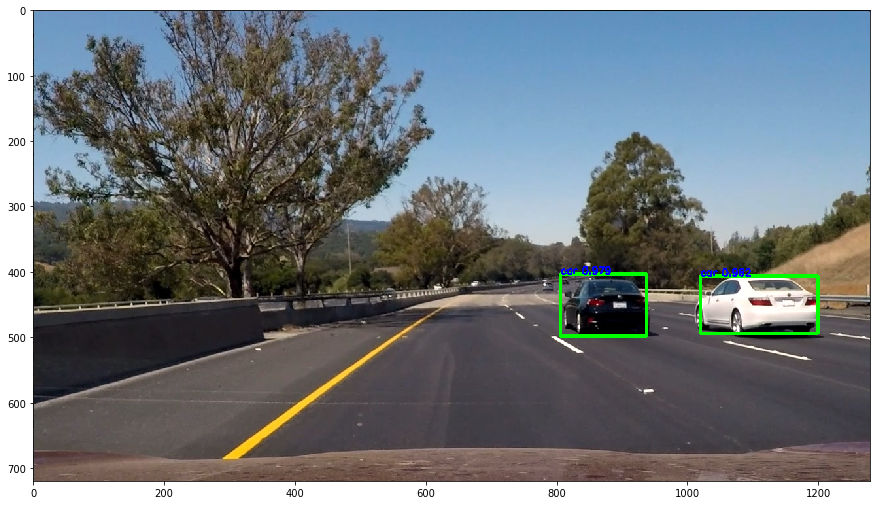

In [32]:
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

image_name = './test6.jpg'
start = time.time()
result = model.predict(image_name, eval_transforms)
# pdx.det.visualize(image_name, result, threshold=0.5, save_dir='./output/')
print('infer time:{:.6f}s'.format(time.time()-start))
print('detected num:', len(result))

im = cv2.imread(image_name)
font = cv2.FONT_HERSHEY_SIMPLEX
threshold = 0.5

for value in result:
    xmin, ymin, w, h = np.array(value['bbox']).astype(np.int)
    cls = value['category']
    score = value['score']
    if score < threshold:
        continue
    cv2.rectangle(im, (xmin, ymin), (xmin+w, ymin+h), (0, 255, 0), 4)
    cv2.putText(im, '{:s} {:.3f}'.format(cls, score),
                    (xmin, ymin), font, 0.5, (255, 0, 0), thickness=2)

cv2.imwrite('result.jpg', im)
plt.figure(figsize=(15,12))
plt.imshow(im[:, :, [2,1,0]])
plt.show()

# 10. 定义车道线检测模型：

这里使用了开源的项目：

[https://github.com/Sharpiless/advanced_lane_detection](https://github.com/Sharpiless/advanced_lane_detection)

该车道检测算法流程为：

* 给定一组棋盘图像（在camera_cal文件夹内），计算相机校准矩阵和失真系数。

![](https://ai-studio-static-online.cdn.bcebos.com/b3db1d85345444d2b911e817f59399664d34945ce2704605a26657978370d87e)


* 根据校准矩阵和失真系数对原始图像应用失真校正。

* 使用颜色变换，渐变等创建阈值二进制图像。

![](https://ai-studio-static-online.cdn.bcebos.com/0d13bfa4c3a942b68d180bc4e66b040446b2dbaa6bf84c66bc9ce4e1515a5361)


* 应用透视变换以校正二进制图像（“鸟瞰”）。

![](https://ai-studio-static-online.cdn.bcebos.com/6e917cefbe3d40e589d82f1e4e274f11114a616342d94f1c968a064ba9d74ab7)


* 检测图像中车道像素并拟合，以找到车道边界。

![](https://ai-studio-static-online.cdn.bcebos.com/29b9d34c6c6744598d588421a52be7f19652a8327df04c49851182e2828f5969)


* 将检测到的车道边界矫正到原始图像。

![](https://ai-studio-static-online.cdn.bcebos.com/b58e2bb4fd2d41f2880e13959c6263518ca9f8097586472dab2d4e967cde3586)


In [27]:
import pickle, glob, os
import matplotlib.image as mpimg
import tools


from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
class GlobalObjects:

    def __init__(self):
        self.__set_folders()
        self.__set_hyper_parameters()
        self.__set_perspective()
        self.__set_kernels()
        self.__set_mask_regions()

    def __set_folders(self):
        # Use one slash for paths.
        self.camera_cal_folder = 'camera_cal/'
        self.test_images = glob.glob('test_images/*.jpg')
        self.output_image_path = 'output_images/test_'
        self.output_movie_path = 'output_movies/done_'


    def __set_hyper_parameters(self):
        self.img_size   = (1280, 720) # (x,y) values for img size (cv2 uses this)
        self.img_shape  = (self.img_size[1], self.img_size[0]) # (y,x) As numpy spits out
        return

    def __set_kernels(self):
        """Kernels used for image processing"""
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    def __set_perspective(self):
        """The src points draw a persepective trapezoid, the dst points draw
        them as a square.  M transforms x,y from trapezoid to square for
        a birds-eye view.  M_inv does the inverse.
        """

        src = np.float32([[(.42 * self.img_shape[1],.65 * self.img_shape[0] ),
                           (.58 * self.img_shape[1], .65 * self.img_shape[0]),
                           (0 * self.img_shape[1],self.img_shape[0]),
                           (1 * self.img_shape[1], self.img_shape[0])]])

        dst = np.float32([[0,0],
                          [self.img_shape[1],0],
                          [0,self.img_shape[0]],
                          [self.img_shape[1],self.img_shape[0]]])

        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def __set_mask_regions(self):
        """These are verticies used for clipping the image.
        """
        self.bottom_clip = np.int32(np.int32([[[60,0], [1179,0], [1179,650], [60,650]]]))
        self.roi_clip =  np.int32(np.int32([[[640, 425], [1179,550], [979,719],
                              [299,719], [100, 550], [640, 425]]]))

In [29]:
class LaneFinder(object):
    """
    The mighty LaneFinder takes in a video from the front camera of a self driving car
    and produces a new video with the traffic lanes highlighted and statistics about where
    the car is relative to the center of the lane shown.
    """    
    
    def __init__(self):

        self.g             = GlobalObjects()        
        self.thresholder   = tools.ImageThresholder()
        self.distCorrector = tools.DistortionCorrector(self.g.camera_cal_folder)
        self.histFitter    = tools.HistogramLineFitter()
        self.laneDrawer    = tools.LaneDrawer()
        self.leftLane      = tools.Line()
        self.rightLane     = tools.Line()

        return

    def __image_pipeline(self, img):
        """The pipeline for processing images. Globals g are added to functions that need
        access to global variables.
        """
        resized     = self.__resize_image(img)
        undistorted = self.__correct_distortion(resized)
        warped      = self.__warp_image_to_biv(undistorted)
        thresholded = self.__threshold_image(warped)
        lines       = self.__get_lane_lines(thresholded)
        result      = self.__draw_lane_lines(undistorted, thresholded, include_stats=False)

        return result


    def __draw_lane_lines(self, undistorted, thresholded, include_stats):

        lines = {'left_line': self.leftLane,
                 'right_line': self.rightLane }

        return self.laneDrawer.draw_lanes(undistorted,
                                          thresholded,
                                          lines,
                                          self.g.M_inv,
                                          include_stats)

    def __get_lane_lines(self, img):

        self.leftLane    = self.histFitter.get_line(img, self.leftLane, 'left')
        self.rightLane   = self.histFitter.get_line(img, self.rightLane, 'right')

        return True

    def __mask_region(self, img, vertices):
        """
        Masks a region specified by clockwise vertices.
        """

        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        cv2.fillConvexPoly(mask, vertices, ignore_mask_color)
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image 

    def __resize_image(self, img):
        """
        Image is resized to the selected size for the project.
        """
        return cv2.resize(img, self.g.img_size, 
                          interpolation = cv2.INTER_CUBIC)

    def __correct_distortion(self, img):
        return self.distCorrector.undistort(img)

    def __threshold_image(self, img):
        return self.thresholder.get_thresholded_image(img)

    def __warp_image_to_biv(self, img):
        return cv2.warpPerspective(img, self.g.M, self.g.img_size)


    def test_one_image(self, pt):
        image = (mpimg.imread(pt))
        return self.__image_pipeline(image)


# 最终效果：


Loading saved calibration file...
<class 'numpy.ndarray'> (720, 1280, 3)


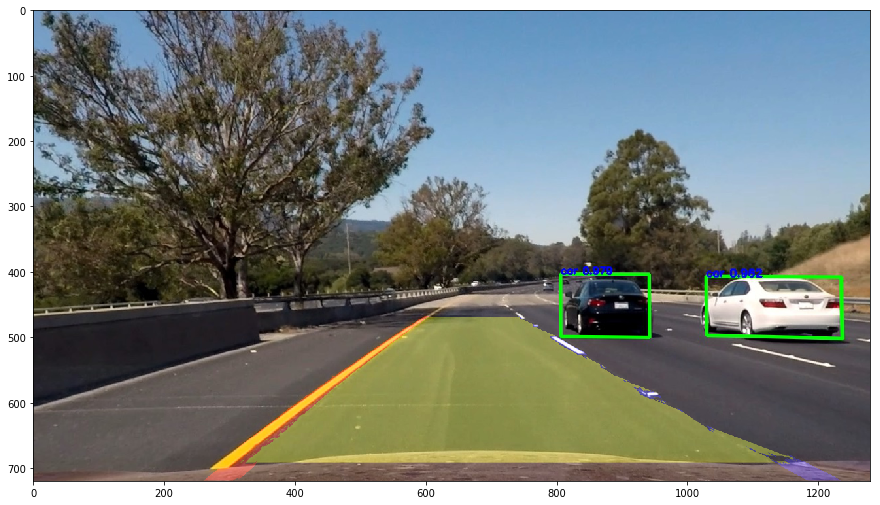

In [34]:
obj = LaneFinder()
result = obj.test_one_image('./result.jpg')
print(type(result), result.shape)

plt.figure(figsize=(15,12))
plt.imshow(result)
plt.show()

# 11. 总结：

### 在本项目中我们完成了以下任务：

1. 使用PaddleX在车辆检测数据集训练了YOLOv3模型；

2. 使用训练好的YOLOv3模型进行车辆的检测；

3. 使用开源算法实现了车道线的检测；

### 结论：

PaddleX提供的模型训练和部署接口非常实用，帮助提高开发者的开发效率；

### 可改进的地方：

1. 不同道路区域有不同的行驶规则，按照车辆朝向判断逆行方法需要改进；

2. 可以使用Paddleseg去训练端到端的车道线分割模型；

## 关于作者：
> 北京理工大学 大二在读

> 感兴趣的方向为：目标检测、人脸识别、EEG识别等

> 将会定期分享一些小项目，感兴趣的朋友可以互相关注一下：[主页链接](http://aistudio.baidu.com/aistudio/personalcenter/thirdview/67156)

> 也欢迎大家fork、评论交流

> 作者博客主页：[https://blog.csdn.net/weixin_44936889](https://blog.csdn.net/weixin_44936889)

